# Reducing traffic mortality

In [1]:
import pandas as pd
import math
from bokeh.plotting import figure
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import scatter_matrix
from bokeh.io import output_notebook, show
pd.set_option('display.max_colwidth', 0)

## The raw data files and their format

In [2]:
dfm = pd.read_csv('miles-driven.csv')

In [3]:
dfm.head()

,state|million_miles_annually
0,Alabama|64914
1,Alaska|4593
2,Arizona|59575
3,Arkansas|32953
4,California|320784


In [4]:
dfm = dfm["state|million_miles_annually"].str.split("|", expand=True)


In [5]:
dfm.rename(columns={0: 'state', 1: 'million_miles_annually'}, inplace=True)
dfm = dfm.astype({"million_miles_annually": int}, errors='raise') 
dfm.head()

,state,million_miles_annually
0,Alabama,64914
1,Alaska,4593
2,Arizona,59575
3,Arkansas,32953
4,California,320784


In [6]:
dfm.describe()

,million_miles_annually
count,51.000000
mean,57851.019608
std,59898.414088
min,3568.000000
25%,17450.000000
50%,46606.000000
75%,71922.500000
max,320784.000000


In [7]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   state                   51 non-null     object
 1   million_miles_annually  51 non-null     int32 
dtypes: int32(1), object(1)
memory usage: 740.0+ bytes


In [8]:
dfr = pd.read_csv('road-accidents.csv')
dfr = pd.DataFrame(dfr)
dfr.head()

,##### LICENSE #####
0,# This data set is modified from the original at fivethirtyeight (https://github.com/fivethirtyeight/data/tree/master/bad-drivers)
1,# and it is released under CC BY 4.0 (https://creativecommons.org/licenses/by/4.0/)
2,##### COLUMN ABBREVIATIONS #####
3,# drvr_fatl_col_bmiles = Number of drivers involved in fatal collisions per billion miles (2011)
4,# perc_fatl_speed = Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding (2009)


In [9]:
abreviations = dfr.iloc[3:7,:]
abreviations = abreviations["##### LICENSE #####"].str.split("=", expand=True)
abreviations.rename(columns={0: 'abreviation', 1: 'original title'}, inplace=True)
abreviations

,abreviation,original title
3,# drvr_fatl_col_bmiles,Number of drivers involved in fatal collisions per billion miles (2011)
4,# perc_fatl_speed,Percentage Of Drivers Involved In Fatal Collisions Who Were Speeding (2009)
5,# perc_fatl_alcohol,Percentage Of Drivers Involved In Fatal Collisions Who Were Alcohol-Impaired (2011)
6,# perc_fatl_1st_time,Percentage Of Drivers Involved In Fatal Collisions Who Had Not Been Involved In Any Previous Accidents (2011)


In [10]:
dfr_clean = dfr["##### LICENSE #####"].str.split("|", expand=True)
dfr_clean.drop([0,1,2,3,4,5,6,7,8],inplace=True)
dfr_clean.columns = ["state", "drvr_fatl_col_bmiles", "perc_fatl_speed", "perc_fatl_alcohol", "perc_fatl_1st_time"]
dfr_clean = dfr_clean.reset_index()
del dfr_clean['index']
dfr_clean

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,Alabama,18.8,39,30,80
1,Alaska,18.1,41,25,94
2,Arizona,18.6,35,28,96
3,Arkansas,22.4,18,26,95
4,California,12,35,28,89
5,Colorado,13.6,37,28,95
6,Connecticut,10.8,46,36,82
7,Delaware,16.2,38,30,99
8,District of Columbia,5.9,34,27,100
9,Florida,17.9,21,29,94


## Create a textual and a graphical summary of the data

In [11]:
output_notebook()
X = dfm['state']
Y = dfm['million_miles_annually']

p = figure(x_range = X, width = 900, title="million_miles_annually per state", x_axis_label='state', 
           y_axis_label='million_miles_annually', toolbar_location=None, tools="")

p.vbar(x = X, top=Y, width=0.5)
p.xaxis.major_label_orientation = math.pi/2
p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

Loading BokehJS ...

In [12]:
output_notebook()
X = dfr_clean['state']
Y = dfr_clean['drvr_fatl_col_bmiles']

p = figure(x_range = X, width = 900, title="Number of drivers involved in fatal collisions per billion miles 2011", x_axis_label='state', 
           y_axis_label='Number of drivers involved in fatal collisions per billion miles 2011', toolbar_location=None, tools="")

p.vbar(x = X, top=Y, width=0.5)
p.xaxis.major_label_orientation = math.pi/2
p.xgrid.grid_line_color = None
p.y_range.start = 0
show(p)

Loading BokehJS ...

In [13]:
dfr_clean = dfr_clean.astype({"drvr_fatl_col_bmiles": float}, errors='raise') 
dfr_clean = dfr_clean.astype({"perc_fatl_speed": int}, errors='raise') 
dfr_clean = dfr_clean.astype({"perc_fatl_alcohol": int}, errors='raise') 
dfr_clean = dfr_clean.astype({"perc_fatl_1st_time": int}, errors='raise') 

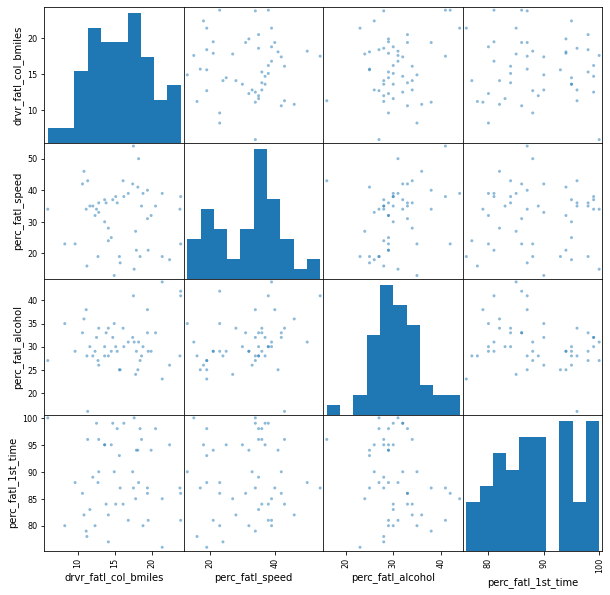

In [14]:
features = ["drvr_fatl_col_bmiles", "perc_fatl_speed", "perc_fatl_alcohol", "perc_fatl_1st_time"]
scatter_matrix(dfr_clean[features], figsize=(10,10))
plt.show()

## Quantify the association of features and accidents

In [15]:
# Pearson correlation coefficient 
dfr_clean.corr(method ='pearson')

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
drvr_fatl_col_bmiles,1.000000,-0.029080,0.199426,-0.017942
perc_fatl_speed,-0.029080,1.000000,0.286244,0.014066
perc_fatl_alcohol,0.199426,0.286244,1.000000,-0.245455
perc_fatl_1st_time,-0.017942,0.014066,-0.245455,1.000000


In [16]:
regress_df = dfr_clean.copy()
del regress_df['state']
regress_df.head()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,18.8,39,30,80
1,18.1,41,25,94
2,18.6,35,28,96
3,22.4,18,26,95
4,12.0,35,28,89


In [17]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(regress_df.drop('drvr_fatl_col_bmiles',axis='columns'),regress_df.drvr_fatl_col_bmiles)

LinearRegression()

In [18]:
# regression coefficient
reg.coef_

array([-0.04180041,  0.19086404,  0.02473301])

In [19]:
reg.intercept_

9.064980483403303

In [20]:
reg.predict([[50, 50, 50]])

array([17.75481187])

masking relationship : the regression coefficient of feature perc_fatl_1st_time is positive, while the correlation coefficient is negative

## Perform PCA on standardized data

In [21]:
features_pca = ["perc_fatl_speed", "perc_fatl_alcohol", "perc_fatl_1st_time"]

In [22]:
#Standardize the Data
from sklearn.preprocessing import StandardScaler
# features
X = dfr_clean[features]
# target
y = dfr_clean['drvr_fatl_col_bmiles']


In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled


array([[ 0.73744574,  0.76264511, -0.1350496 , -1.26611685],
       [ 0.56593556,  0.97232113, -1.1189824 ,  0.76536053],
       [ 0.68844283,  0.34329308, -0.52862272,  1.05557158],
       [ 1.61949811, -1.43895304, -0.92219584,  0.91046605],
       [-0.92865317,  0.34329308, -0.52862272,  0.03983289],
       [-0.5366299 ,  0.5529691 , -0.52862272,  0.91046605],
       [-1.22267063,  1.49651116,  1.04566976, -0.9759058 ],
       [ 0.10040792,  0.6578071 , -0.1350496 ,  1.49088816],
       [-2.42324191,  0.23845508, -0.72540928,  1.63599369],
       [ 0.51693265, -1.12443902, -0.33183616,  0.76536053],
       [-0.04660081, -1.33411503, -1.1189824 ,  0.620255  ],
       [ 0.41892683,  2.33521522,  2.02960256, -0.25037816],
       [-0.12010517,  0.44813109, -0.33183616,  1.34578263],
       [-0.73264154,  0.44813109,  0.65209664,  1.05557158],
       [-0.31611681, -0.70508699, -0.33183616,  0.91046605],
       [-0.02209935, -1.54379105, -1.1189824 , -0.25037816],
       [ 0.4924312 , -0.

In [24]:
df_scale = pd.DataFrame(X_scaled, columns=regress_df.columns)
df_scale.head()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,0.737446,0.762645,-0.135050,-1.266117
1,0.565936,0.972321,-1.118982,0.765361
2,0.688443,0.343293,-0.528623,1.055572
3,1.619498,-1.438953,-0.922196,0.910466
4,-0.928653,0.343293,-0.528623,0.039833


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=30)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
y_train1 = lab_enc.fit_transform(y_train)
y_test1 = lab_enc.fit_transform(y_test)

model = LogisticRegression()
model.fit(X_train, y_train1)
model.score(X_test, y_test1)

0.15384615384615385

## Visualize the first two principal components

In [27]:
from sklearn.decomposition import PCA

pca = PCA(0.76)
X_pca = pca.fit_transform(X)
X_pca.shape

(51, 2)

In [28]:
pca_df_scale = pd.DataFrame(X_pca, columns=['pc1','pc2'])
print(pca.explained_variance_ratio_)

[0.51852071 0.27794446]


In [29]:
pca_df_scale.head()

,pc1,pc2
0,7.130601,-7.672294
1,7.832241,7.309862
2,2.524794,7.816864
3,-14.521312,5.923928
4,2.672486,1.521783


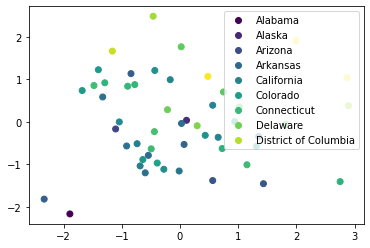

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
pca = PCA()
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
Xt = pipe.fit_transform(X)
plot = plt.scatter(Xt[:,0], Xt[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(dfr_clean['state']))
plt.show()

C:\Users\Noureddine\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'Inertia')

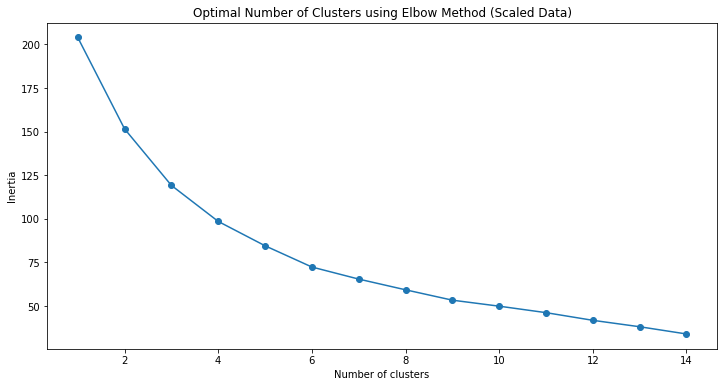

In [31]:
from sklearn.cluster import KMeans
OMP_NUM_THREADS=1
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(df_scale)
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [32]:
from sklearn.metrics import silhouette_score
kmeans_pca_scale = KMeans(n_clusters=3, n_init=100, max_iter=400,
                          init='k-means++', random_state=42).fit(pca_df_scale)
print('KMeans PCA Scaled Silhouette Score: {}'.format(silhouette_score(pca_df_scale, 
                                                    kmeans_pca_scale.labels_, metric='euclidean')))
labels_pca_scale = kmeans_pca_scale.labels_
clusters_pca_scale = pd.concat([pca_df_scale, pd.DataFrame({'pca_clusters':labels_pca_scale})], axis=1)

KMeans PCA Scaled Silhouette Score: 0.4606148050131864


C:\Users\Noureddine\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


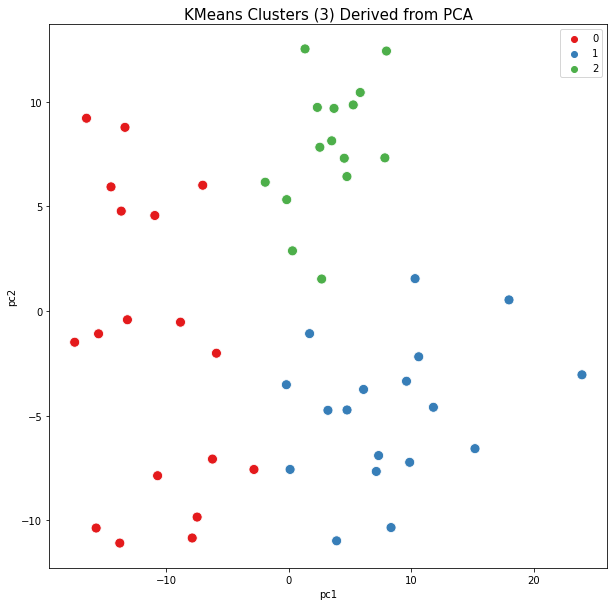

In [33]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.scatterplot(clusters_pca_scale.iloc[:,0],clusters_pca_scale.iloc[:,1], 
                hue=labels_pca_scale, palette='Set1', s=100).set_title('KMeans Clusters (3) Derived from PCA'
                , fontsize=15)
plt.legend()
plt.show()

## Visualize the feature differences between the clusters

In [34]:
from sklearn.metrics import silhouette_score
kmeans_pca_scale1 = KMeans(n_clusters=3, n_init=100, max_iter=400,
                          init='k-means++', random_state=42).fit(regress_df)
print('KMeans PCA Scaled Silhouette Score: {}'.format(silhouette_score(regress_df, 
                                                    kmeans_pca_scale.labels_, metric='euclidean')))
labels_pca_scale1 = kmeans_pca_scale.labels_
clusters_pca_scale1 = pd.concat([pca_df_scale, pd.DataFrame({'pca_clusters':labels_pca_scale1})], axis=1)

KMeans PCA Scaled Silhouette Score: 0.3205416123409079


C:\Users\Noureddine\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


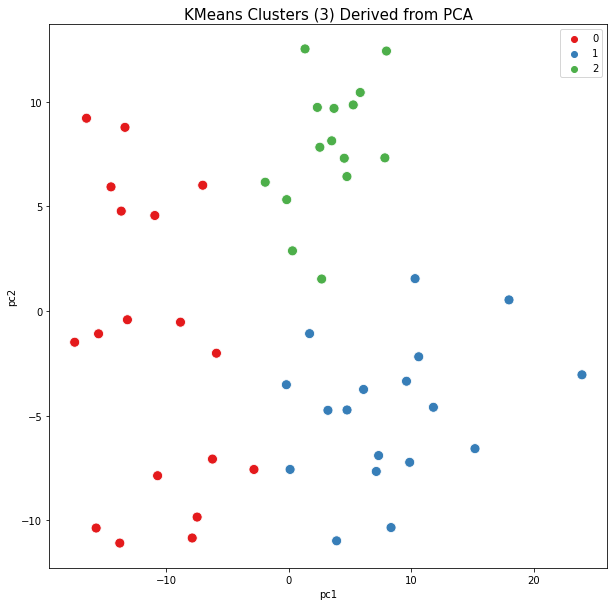

In [35]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.scatterplot(clusters_pca_scale1.iloc[:,0],clusters_pca_scale1.iloc[:,1], 
                hue=labels_pca_scale1, palette='Set1', s=100).set_title('KMeans Clusters (3) Derived from PCA'
                , fontsize=15)
plt.legend()
plt.show()

by using unscaled features we see that the distance bewtween the 3 clusters are less than we we used scaled features

## Compute the number of accidents within each cluster

In [36]:
#adding a column for total fatal accident in each state
column = np.array((dfm['million_miles_annually']) * (dfr_clean['drvr_fatl_col_bmiles']))
dfr_clean = dfr_clean.assign(Total_ftl_acc = column)
dfr_clean.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time,Total_ftl_acc
0,Alabama,18.8,39,30,80,1220383.2
1,Alaska,18.1,41,25,94,83133.3
2,Arizona,18.6,35,28,96,1108095.0
3,Arkansas,22.4,18,26,95,738147.2
4,California,12.0,35,28,89,3849408.0


### GET clusters

In [37]:
all_clus = {i: np.where(kmeans_pca_scale1.labels_ == i)[0] for i in range(kmeans_pca_scale1.n_clusters)}
all_clus

{0: array([ 0,  6, 11, 19, 25, 26, 29, 32, 33, 38, 39, 40, 41, 43, 47, 48, 49,
        50], dtype=int64),
 1: array([ 1,  2,  4,  5,  7,  8, 12, 13, 18, 20, 28, 36, 37, 44, 45],
       dtype=int64),
 2: array([ 3,  9, 10, 14, 15, 16, 17, 21, 22, 23, 24, 27, 30, 31, 34, 35, 42,
        46], dtype=int64)}

In [38]:
cluster1 = [dfr_clean['state'][e] for e in all_clus[0]]    
cluster2 = [dfr_clean['state'][e] for e in all_clus[1]]  
cluster3 = [dfr_clean['state'][e] for e in all_clus[2]]  

In [39]:
all_clusters = { 1: cluster1, 2: cluster2, 3: cluster3}

In [40]:
all_clusters

{1: ['Alabama',
  'Connecticut',
  'Hawaii',
  'Maine',
  'Missouri',
  'Montana',
  'New Hampshire',
  'New York',
  'North Carolina',
  'Pennsylvania',
  'Rhode Island',
  'South Carolina',
  'South Dakota',
  'Texas',
  'Washington',
  'West Virginia',
  'Wisconsin',
  'Wyoming'],
 2: ['Alaska',
  'Arizona',
  'California',
  'Colorado',
  'Delaware',
  'District of Columbia',
  'Idaho',
  'Illinois',
  'Louisiana',
  'Maryland',
  'Nevada',
  'Oklahoma',
  'Oregon',
  'Utah',
  'Vermont'],
 3: ['Arkansas',
  'Florida',
  'Georgia',
  'Indiana',
  'Iowa',
  'Kansas',
  'Kentucky',
  'Massachusetts',
  'Michigan',
  'Minnesota',
  'Mississippi',
  'Nebraska',
  'New Jersey',
  'New Mexico',
  'North Dakota',
  'Ohio',
  'Tennessee',
  'Virginia']}

In [41]:
data1 = np.array([dfr_clean['Total_ftl_acc'][e] for e in all_clus[0]]).astype(int)
data2 = np.array([dfr_clean['Total_ftl_acc'][e] for e in all_clus[1]]).astype(int)
data3 = np.array([dfr_clean['Total_ftl_acc'][e] for e in all_clus[2]]).astype(int)


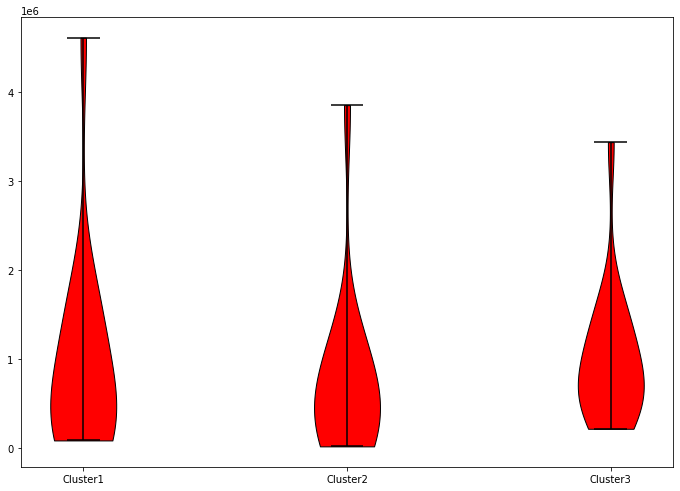

In [44]:
a4_dims = (11.7, 8.27)

fig,ax = plt.subplots(figsize=a4_dims)
dataset = [data1,data2,data3]

vp = ax.violinplot( dataset=dataset, positions=[2,4,6])
ax.set_xticks([2, 4, 6])
ax.set_xticklabels(['Cluster1', 'Cluster2', 'Cluster3'])

for body in vp['bodies']:
    body.set_facecolor('red')
    body.set_edgecolor('black')
    body.set_alpha(1)
    
vp['cmaxes'].set_color('black')
vp['cmins'].set_color('black')
vp['cbars'].set_color('black')


## Make a decision when there is no clear right choice

According to our analysis, I see that the cluster1 should be a focus for policy intervention and further investigation, because 
as we can see in the violin plot there is a clear difference between the 1 cluster and the 2 others.
the cluster1's states are bellow :

In [45]:
cluster1

['Alabama',
 'Connecticut',
 'Hawaii',
 'Maine',
 'Missouri',
 'Montana',
 'New Hampshire',
 'New York',
 'North Carolina',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Texas',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']